In [1]:
device = 'cuda'

In [2]:
import numpy as np 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
def weights_init_R2R(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        # nn.init.uniform(m.weight.data, 1.0, 0.02)
        m.weight.data.normal_(mean=0, std=math.sqrt(2./9./64.)).clamp_(-0.025,0.025)
        nn.init.constant_(m.bias.data, 0.0)

In [4]:
from scipy.io import loadmat
data=loadmat("data.mat")
dtrue=data["d"]
dntrue=data["dn"]
bntrue=data["bn"]
d=dtrue/np.max(np.abs(dtrue))
dn=dntrue/np.max(np.abs(dtrue))
bn=bntrue/np.max(np.abs(dtrue))
dn1=dn+0.5*bn
dn2=dn-bn/0.5

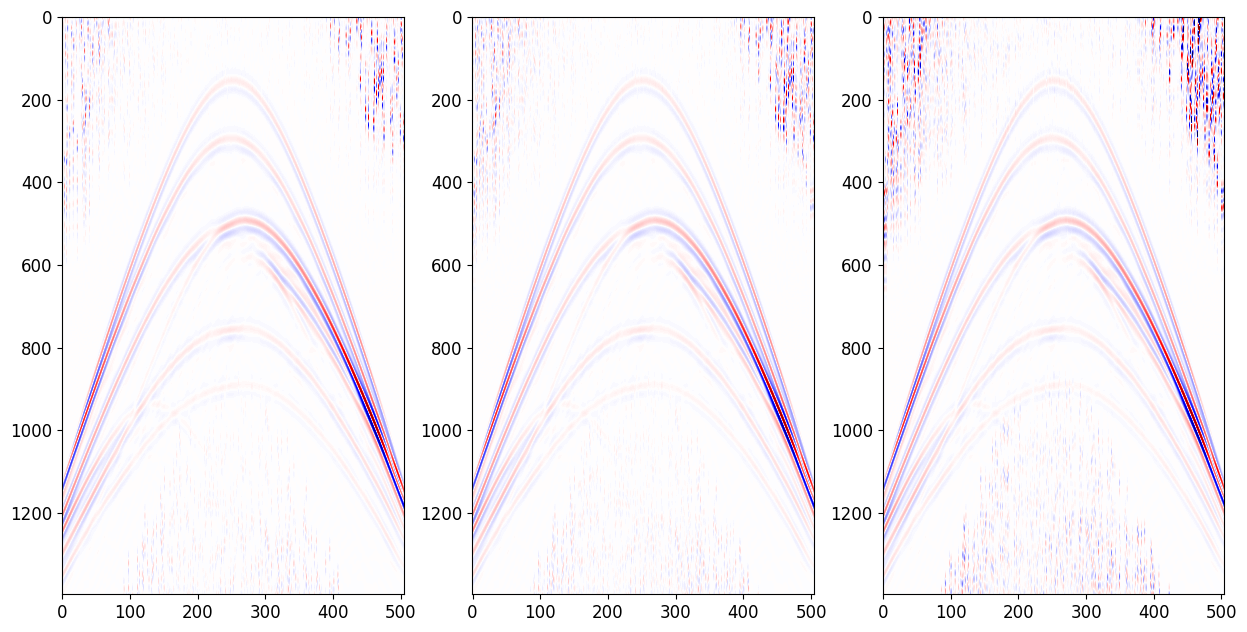

In [5]:
plt.figure(figsize=(15,7.5))
plt.rcParams.update({'font.size':12})
plt.subplot(131)
plt.imshow(dn,aspect='auto',vmin=-1,vmax=1,cmap='seismic')
plt.subplot(132)
plt.imshow(dn1,aspect='auto',vmin=-1,vmax=1,cmap='seismic')
plt.subplot(133)
plt.imshow(dn2,aspect='auto',vmin=-1,vmax=1,cmap='seismic')

In [6]:
clean_img=torch.from_numpy(np.expand_dims(np.expand_dims(d,axis=0),axis=0)).float()
noisy_img=torch.from_numpy(np.expand_dims(np.expand_dims(dn,axis=0),axis=0)).float()
clean_img = clean_img.to(device)
noisy_img = noisy_img.to(device)

In [7]:
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x)
        return x-out
    
n_chan = clean_img.shape[1]
model = DnCNN(n_chan,num_of_layers=10)
model = model.apply(weights_init_R2R) 
model = model.to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))    

The number of parameters of the network is:  297088


In [8]:
noisy1=torch.from_numpy(np.expand_dims(np.expand_dims(dn2,axis=0),axis=0)).float()
noisy2=torch.from_numpy(np.expand_dims(np.expand_dims(dn1,axis=0),axis=0)).float()
noisy1 = noisy1.to(device)
noisy2 = noisy2.to(device)

In [9]:
def denoise(model, noisy_img):
    
    with torch.no_grad():
        pred = torch.clamp( noisy_img - model(noisy_img),-1,1)
    
    return pred 

In [10]:
max_epoch =50 # training epochs
lr = 1e-3  # learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=False)
torch.cuda.empty_cache()
for epoch in tqdm(range(max_epoch)):
    pred1 =  noisy1 - model(noisy1)
    pred2 =  noisy2 - model(noisy2)
    loss  = nn.L1Loss()(noisy1,pred2)+nn.L1Loss()(noisy2,pred1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss) 

  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
denoised_img = denoise(model, noisy_img)
denoised = denoised_img.detach().cpu().numpy().squeeze()

Text(0.5, 1.0, 'Error')

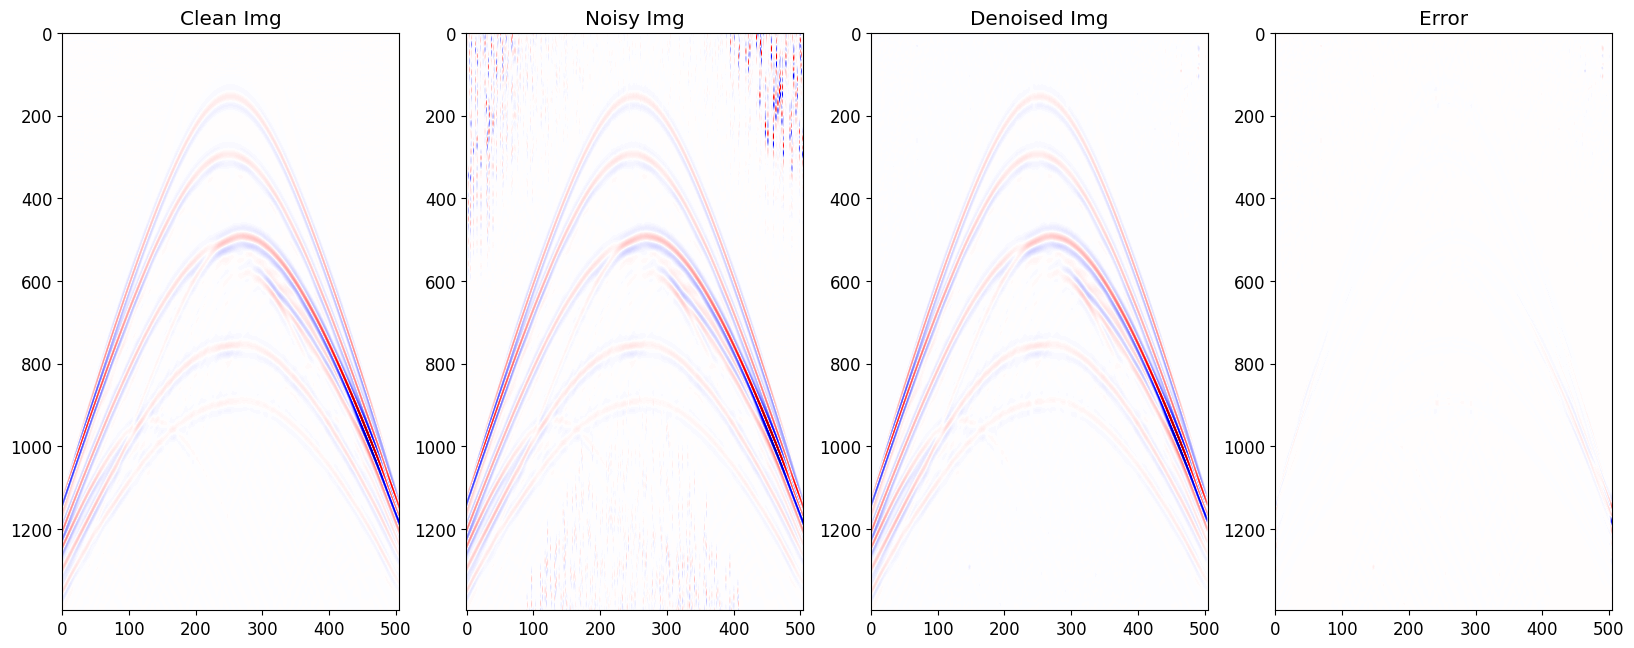

In [13]:
plt.figure(figsize=(20,7.5))
plt.rcParams.update({'font.size':12})
plt.subplot(141)
plt.imshow(d,aspect='auto',vmin=-1,vmax=1,cmap='seismic')
plt.title('Clean Img')
plt.subplot(142)
plt.imshow(dn,aspect='auto',vmin=-1,vmax=1,cmap='seismic')
plt.title('Noisy Img')
plt.subplot(143)
plt.imshow(denoised,aspect='auto',vmin=-1,vmax=1,cmap='seismic')
plt.title('Denoised Img')
plt.subplot(144)
plt.imshow(d-denoised,aspect='auto',vmin=-1,vmax=1,cmap='seismic')
plt.title('Error')